<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/notebooks/train_simple_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Activation, CuDNNGRU, CuDNNLSTM, GRU, Dense, Dropout, Conv1D, Lambda, Concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler
from collections import OrderedDict, defaultdict
from keras.optimizers import Adam
from google.colab import drive
from sklearn.utils import shuffle
import time
drive.mount('/content/drive', force_remount=True)
plt.rcParams['figure.figsize'] = [10, 8]

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
num_features=11

In [0]:
# convolutional layer parameters
n_filters = 64
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, num_features))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters, 
               kernel_size=filter_width, 
               padding='causal', 
               dilation_rate=dilation_rate)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(num_features)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':7})(x)

In [0]:
train = np.load('drive/My Drive/train_set3.npy')
# train = np.concatenate((train, val), axis=1)

In [0]:
train.shape

(16384, 200, 11)

In [0]:
train.shape

(16384, 200, 11)

In [0]:
# reshape training set
window = 7
pred_step = 7

In [0]:
# reshape training set
encoder_input = []
decoder_output = []
for j in range(window, train.shape[1]-pred_step+1): # for each timestep
  for i in range(16384): # for each content type i
    encoder_input.append([]) # add encoder input sample
    decoder_output.append([]) # add decoder input sample
    for w in range(window): # add lagged features
      encoder_input[-1].append(train[i, j-window+w, :num_features])
    for p in range(pred_step): # add true labels for desired pred length
      decoder_output[-1].append(train[i, j+p, :num_features])
encoder_input = np.asarray(encoder_input, dtype='float')
decoder_output = np.asarray(decoder_output, dtype='float')
# decoder has last element of encoder input concatenated with all elements of 

In [0]:
np.save('drive/My Drive/conv_encoder_input.npy', encoder_input)
np.save('drive/My Drive/conv_decoder_output.npy', decoder_output)

In [0]:
encoder_input = np.load('drive/My Drive/conv_encoder_input.npy')
decoder_output = np.load('drive/My Drive/conv_decoder_output.npy')

In [0]:
encoder_input.shape

(3063808, 7, 11)

In [0]:
decoder_output.shape

(3063808, 7, 11)

In [0]:
# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_output[:,:-1,:num_features]
encoder_input = np.concatenate([encoder_input, lagged_target_history], axis=1)

In [0]:
lagged_target_history.shape

(3063808, 6, 11)

In [0]:
model = Model(history_seq, pred_seq_train)
model.compile(Adam(lr=0.001), loss='mean_absolute_error')

In [0]:
history = model.fit(encoder_input, decoder_output, batch_size=256, epochs=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
3063808/3063808 [==============================] - 215s 70us/step - loss: 0.0044


In [0]:
def predict_sequence(input_sequence):
  history_sequence = input_sequence.copy()
  pred_sequence = np.zeros((input_sequence.shape[0],pred_step,num_features)) # initialize output (pred_steps time steps)  

  for i in range(pred_step):
    # record next time step prediction (last time step of model output) 
    last_step_pred = model.predict(history_sequence)[:,-1,:num_features]
    pred_sequence[:,i,:num_features] = last_step_pred
    # add the next time step prediction to the history sequence
    history_sequence = np.concatenate([history_sequence, last_step_pred.reshape(-1,1,num_features)], axis=1)

  return pred_sequence

In [0]:
train.shape

(16384, 200, 11)

In [0]:
test = np.load('drive/My Drive/test_set3.npy')

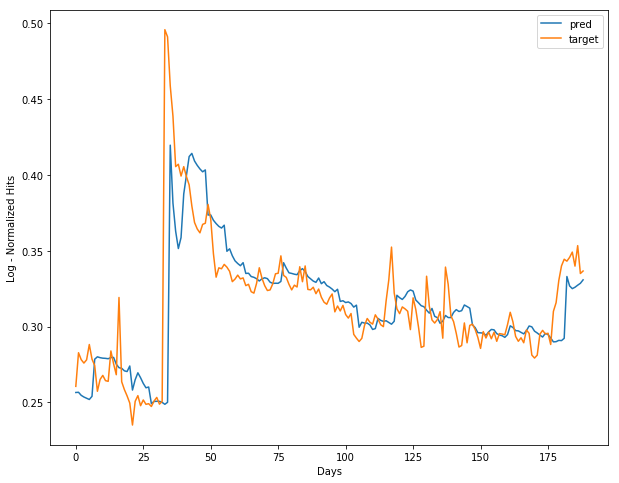

In [0]:
# visualize forecasts
content_ix = 0
encoder_input = []
decoder_output = []
preds = []
for j in range(window, test.shape[1]-pred_step+1, pred_step): # for each timestep
  encoder_input.append([]) # add encoder input sample
  decoder_output.append([]) # add decoder input sample
  for w in range(window): # add lagged features
    encoder_input[-1].append(test[content_ix, j-window+w, :num_features]) # add normalized and relevant features as a training sample
  for p in range(pred_step): # add true labels for desired pred length
    decoder_output[-1].append(test[content_ix, j+p, :num_features]) # add normalized relevent features as a test sample
encoder_input = np.asarray(encoder_input, dtype='float')
decoder_output = np.asarray(decoder_output, dtype='float')
plt.plot(predict_sequence(encoder_input)[:,:,0].flatten())
plt.plot(decoder_output[:,:,0].flatten())
plt.xlabel('Days')
plt.ylabel('Log - Normalized Hits')
plt.legend(['pred','target'])

In [0]:
model.save('drive/My Drive/opt_reshaped_simple_conv_with_portals.h5')

In [0]:
model.predict(encoder_input).shape

(27, 7, 11)

In [0]:
history.history['loss']

[0.004321963630078477]

In [0]:
model = load_model('drive/My Drive/opt_reshaped_simple_conv_with_portals.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 11)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          736       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_______________________________________